In [2]:
# ============================================================
# 0) Colab setup (install + cache dirs)
# ============================================================
!pip -q install datasets pandas numpy matplotlib pillow

import os
os.environ["HF_HOME"] = "/content/hf"
os.environ["HF_DATASETS_CACHE"] = "/content/hf/datasets"
os.environ["TRANSFORMERS_CACHE"] = "/content/hf/transformers"


In [3]:
# ============================================================
# 1) Load / download dataset (Hugging Face Datasets)
# ============================================================
from datasets import load_dataset

ds = load_dataset("daniel3303/StoryReasoning")  # downloads ~773MB the first time
train_hf = ds["train"]
test_hf  = ds["test"]

print(ds)
print("train:", len(train_hf), "test:", len(test_hf))
print("columns:", train_hf.column_names)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story'],
        num_rows: 3552
    })
    test: Dataset({
        features: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story'],
        num_rows: 626
    })
})
train: 3552 test: 626
columns: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story']


In [4]:
# ============================================================
# 2) EDA helpers: parse per-frame text + strip grounding tags
# ============================================================
import re

_GDI = re.compile(r"<gdi\s+image(\d+)>", re.IGNORECASE)
_GD_TAGS = re.compile(r"</?gd[ioal]\b[^>]*>", re.IGNORECASE)  # gdi/gdo/gda/gdl open/close tags
_ANY_TAGS = re.compile(r"<[^>]+>")  # safety

def strip_grounding_tags(text: str) -> str:
    """Remove StoryReasoning grounding XML tags but keep the inner text."""
    if text is None:
        return ""
    text = _GD_TAGS.sub("", text)
    text = _ANY_TAGS.sub("", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def split_story_into_frame_segments(story_text: str):
    """
    Returns dict[frame_index:int] -> segment_text (raw, still with tags unless stripped later).
    Works whether or not there is a closing </gdi> tag (common pattern is just next <gdi ...>).
    """
    if not story_text:
        return {}
    matches = list(_GDI.finditer(story_text))
    if not matches:
        return {}

    segs = {}
    for i, m in enumerate(matches):
        frame_idx = int(m.group(1))
        start = m.end()
        end = matches[i+1].start() if i+1 < len(matches) else len(story_text)
        segs[frame_idx] = story_text[start:end].strip()
    return segs

def get_frame_captions(example):
    """
    Returns a list of cleaned captions aligned to frames:
      captions[0] -> frame 1 segment, captions[1] -> frame 2, ...
    Falls back gracefully if some frame indices are missing.
    """
    frame_count = int(example.get("frame_count", 0))
    segs = split_story_into_frame_segments(example.get("story", ""))
    captions = []
    for i in range(1, frame_count + 1):
        raw = segs.get(i, "")
        captions.append(strip_grounding_tags(raw))
    return captions


In [5]:
# ============================================================
# 3) Basic dataset stats (frame_count distribution)
# ============================================================
import numpy as np
import pandas as pd

frame_counts = np.array([int(x["frame_count"]) for x in train_hf])
df_stats = pd.DataFrame({
    "frame_count": frame_counts,
})

df_stats.describe()


,frame_count
count,3552.000000
mean,12.443412
std,5.028576
min,5.000000
25%,7.000000
50%,13.000000
75%,17.000000
max,22.000000


Train size: 3552 | Test size: 626
Columns: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story']


Aggregating EDA stats (train):   0%|          | 0/3552 [00:00<?, ?it/s]


=== Head ===


,story_id,frame_count,num_images,has_k_plus_1,missing_frame_segments,avg_words_per_frame,median_words_per_frame,max_words_frame,avg_chars_per_frame,var_words_per_frame,images_min_w,images_max_w,images_min_h,images_max_h,images_avg_ar,images_var_ar
0,3920,17,17,1,0,62.117647,61.0,77,368.235294,61.280277,575,575,240,240,2.395833,0.000000e+00
1,1831,19,19,1,0,68.894737,71.0,87,385.947368,56.199446,564,564,240,240,2.350000,0.000000e+00
2,1290,12,12,1,0,96.500000,99.5,116,530.083333,154.416667,426,426,240,240,1.775000,4.930381e-32
3,890,17,17,1,0,76.470588,74.0,98,420.882353,67.307958,446,446,240,240,1.858333,0.000000e+00
4,3163,17,17,1,0,80.352941,80.0,95,466.117647,41.287197,442,442,240,240,1.841667,0.000000e+00



=== Summary (numeric) ===


,frame_count,num_images,has_k_plus_1,missing_frame_segments,avg_words_per_frame,median_words_per_frame,max_words_frame,avg_chars_per_frame,var_words_per_frame,images_min_w,images_max_w,images_min_h,images_max_h,images_avg_ar,images_var_ar
count,3552.000000,3552.000000,3552.0,3552.000000,3552.000000,3552.000000,3552.000000,3552.000000,3552.000000,3552.000000,3552.000000,3552.0,3552.0,3552.000000,3.552000e+03
mean,12.443412,12.443412,1.0,0.000282,80.192612,79.195805,99.090372,460.273422,103.555191,511.701295,511.701295,240.0,240.0,2.132089,5.241306e-32
std,5.028576,5.028576,0.0,0.016779,16.773031,16.860052,20.363924,97.305076,104.653311,67.080503,67.080503,0.0,0.0,0.279502,9.358498e-32
min,5.000000,5.000000,1.0,0.000000,39.684211,38.000000,53.000000,216.157895,2.240000,393.000000,393.000000,240.0,240.0,1.637500,0.000000e+00
25%,7.000000,7.000000,1.0,0.000000,68.293182,67.000000,85.000000,389.677778,49.653827,443.000000,443.000000,240.0,240.0,1.845833,0.000000e+00
50%,13.000000,13.000000,1.0,0.000000,78.242647,77.000000,96.000000,448.272059,78.135605,564.000000,564.000000,240.0,240.0,2.350000,0.000000e+00
75%,17.000000,17.000000,1.0,0.000000,90.114583,89.000000,111.000000,518.191919,122.989630,575.000000,575.000000,240.0,240.0,2.395833,4.930381e-32
max,22.000000,22.000000,1.0,1.000000,152.800000,158.000000,225.000000,909.000000,2408.000000,581.000000,581.000000,240.0,240.0,2.420833,7.888609e-31



=== Integrity checks ===
Duplicate story_id rows: 0
frame_count != num_images: 0 / 3552
Stories with frame_count >= 5: 3552 / 3552


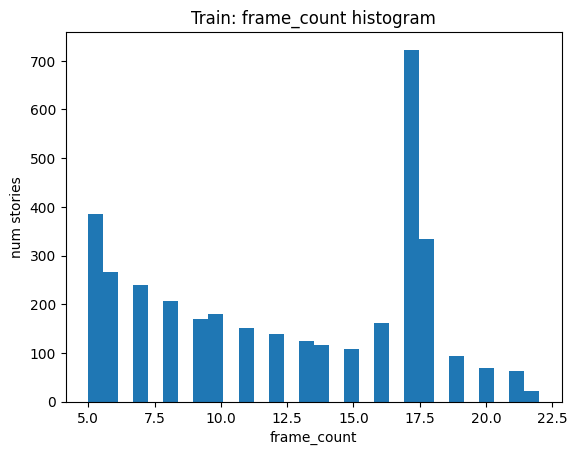

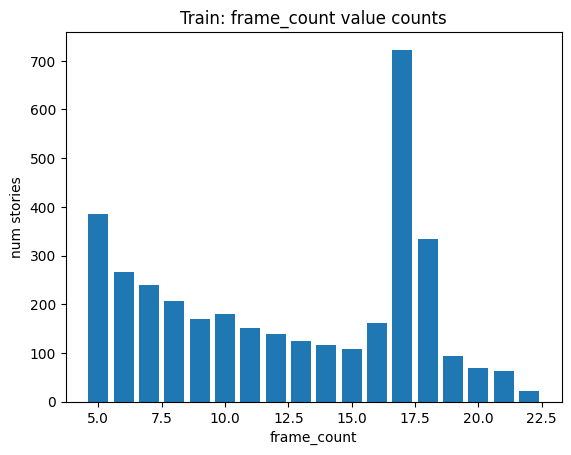

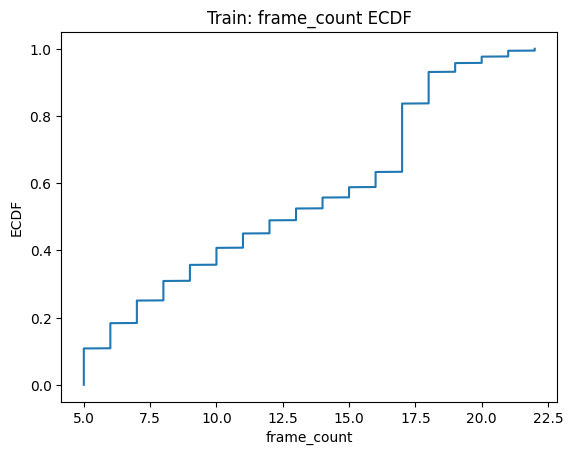

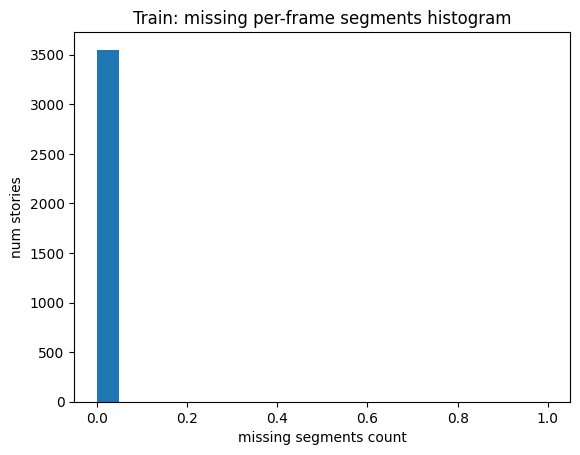

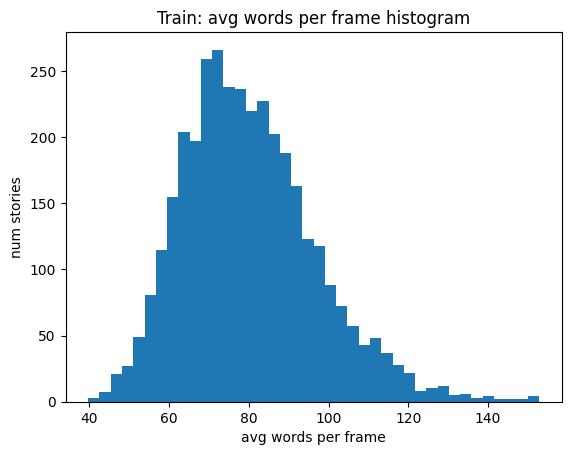

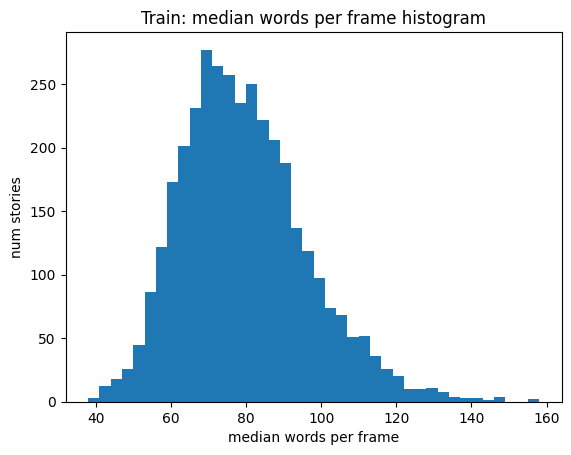

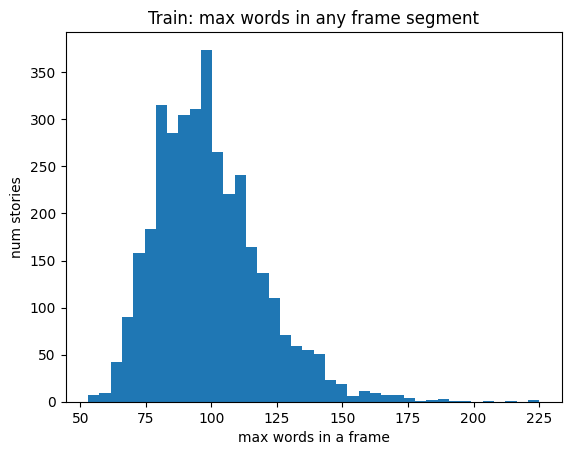

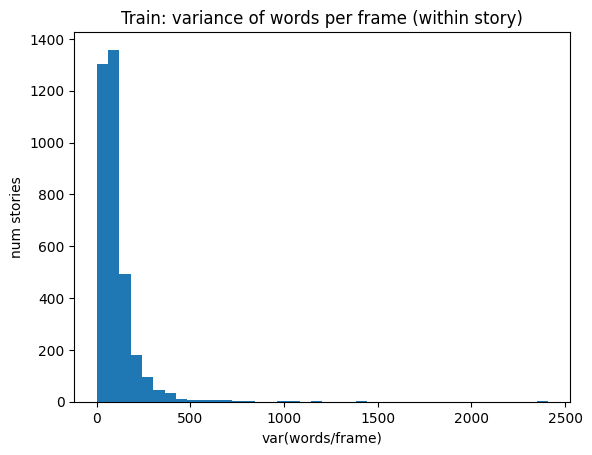

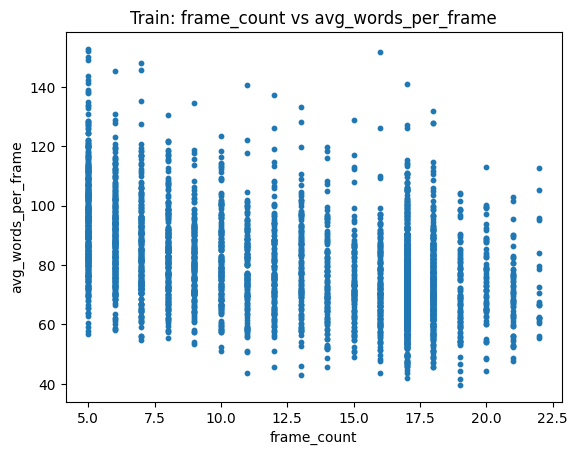

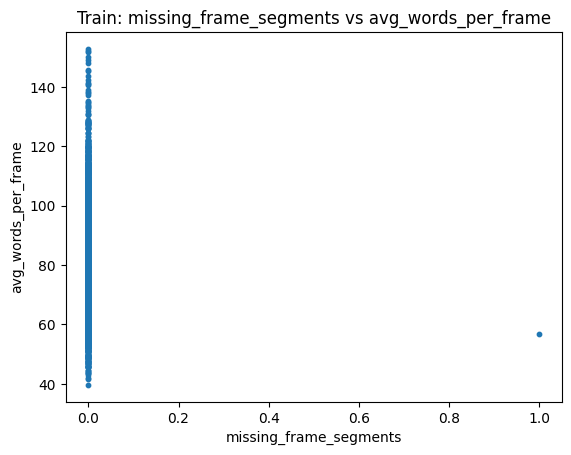

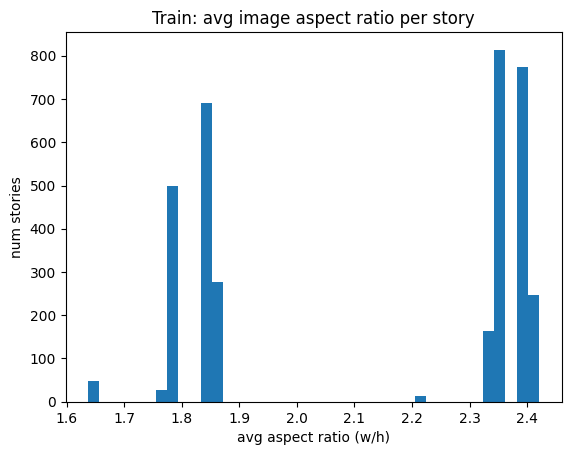

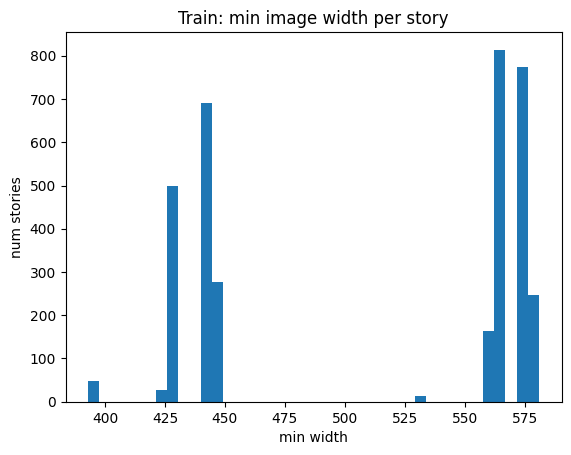

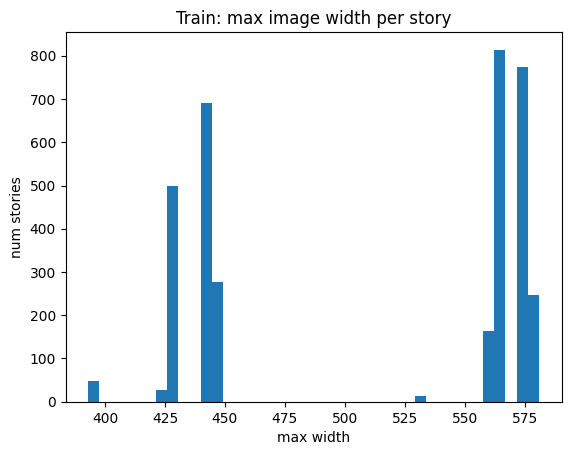

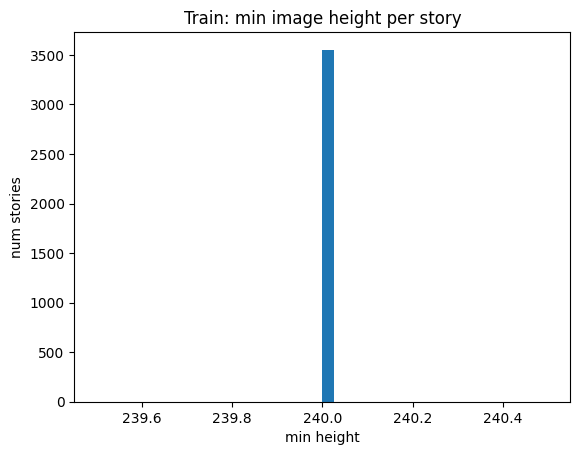

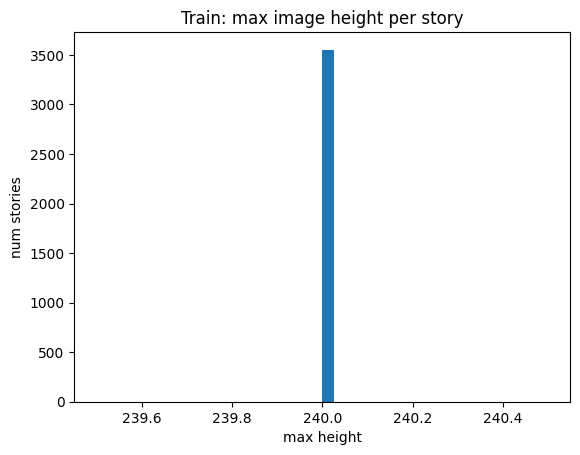

/tmp/ipython-input-3618460653.py:271: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["frame_count"].values, df["avg_words_per_frame"].values, df["missing_frame_segments"].values],


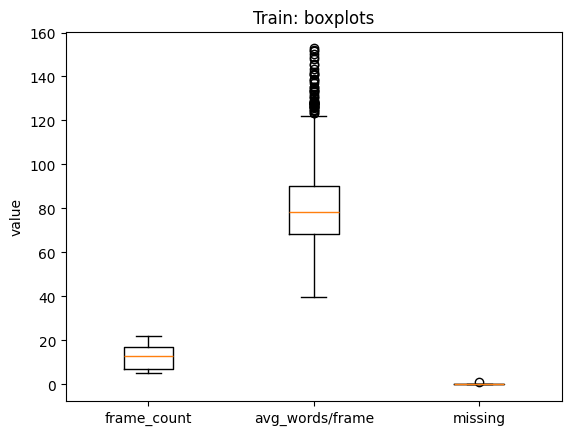

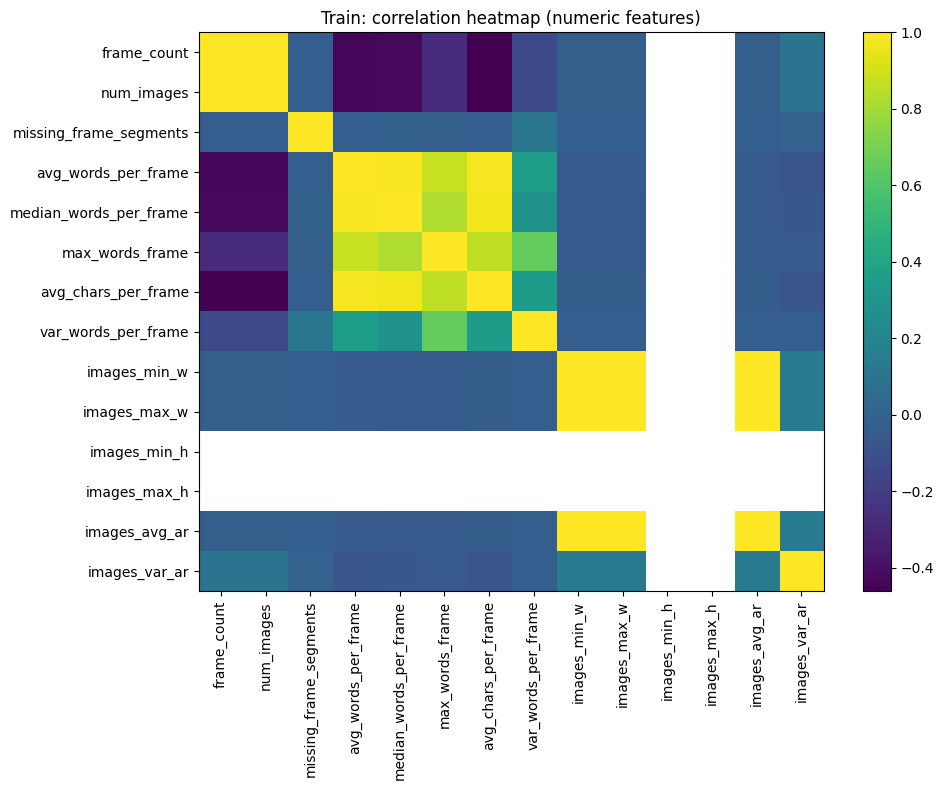

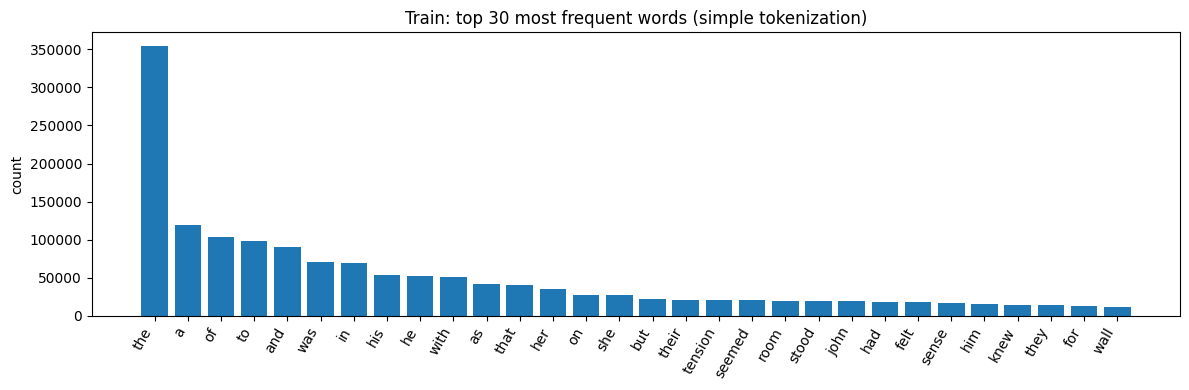


=== Qualitative samples (requires frame_count >= K+1) ===


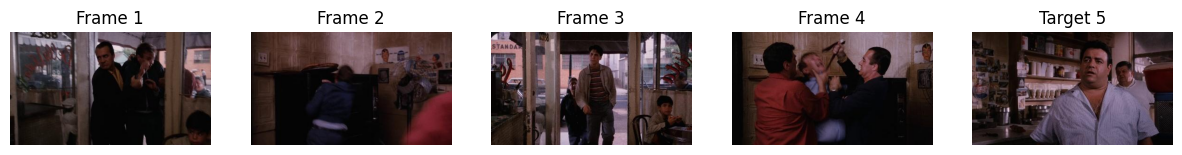

---- Context captions ----
[1] The air in the urban area was heavy with tension as the man in black and the man with his hand on his face exited the building. Their faces, etched with a mix of concern and neutrality, suggested they were grappling with an internal struggle. the young boy observing stood at the door, curiosity lighting up his eyes as he watched the scene unfold. Behind the man in black, the man in the background and the kid in the background remained still, their expressions unreadable. Little did the boy know, this was the beginning of a series of events that would shake their lives.
[2] Inside the dimly lit room, the man with the jacket stood alone, clutching the scissors in his hand. The sharp glint of the metal caught the natural light, adding a sinister edge to the atmosphere. He was deep in thought, replaying the events that had led him to this moment. His heart pounded as he caught a glimpse of the person with a partial view in the foreground, their presence unass

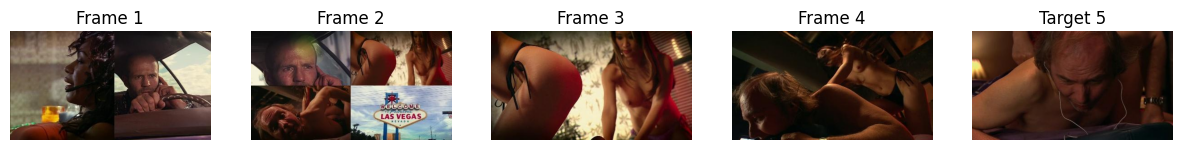

---- Context captions ----
[1] The Sky above was a canvas of possibilities as Tom drove through the bustling streets of Las Vegas, Car interior enclosing him and the vibrant Sarah who sat beside him. Sarah spoke into her headset, her voice calm yet filled with a serious undertone. Tom focused on the road, yet his mind wandered, thinking about the night ahead. Little did he know, this was just the beginning of a night filled with suspense and unexpected turns.
[2] As Tom and Sarah arrived at their destination, Tom parked his car near Welcome to Las Vegas Sign, a glowing landmark under the night sky. Inside a nearby building, Mike and Alex waited, their presence adding an air of tension. Mike, a companion of Tom, watched Alex with a focused gaze, while Alex leaned out of the car, yelling in distress. In the background, Lisa and Diane engaged in playful banter, their laughter contrasting sharply with the rising tension. The atmosphere in the room was already charged with suspense, the Win

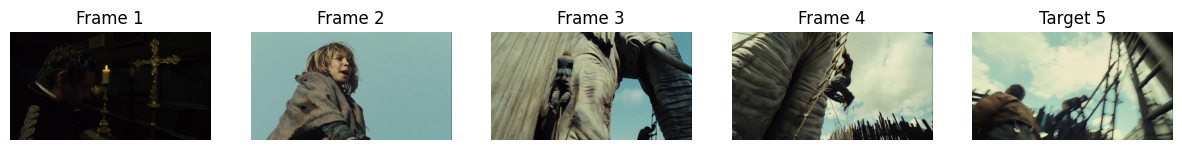

---- Context captions ----
[1] The Man in uniform stood solemnly in the Church interior, his eyes fixed on the Large Cross. The dim light from the Candlestick flickered, casting shadows that danced across the walls. He felt a weight on his shoulders, a burden of responsibility that he had carried since the day he put on the uniform. His mind wandered to the mission ahead, a mission that could change the course of history. As he stood in silence, he whispered a prayer, seeking guidance for the journey that lay ahead.
[2] The open sky stretched out above Young boy, who shouted with determination. bg7 acted as a canvas for his voice, carrying his desperate plea across the horizon. He knew that time was running out; his village was in danger, and only he could reach the others in time. He had been chosen as the messenger, a task that he both feared and embraced. His heart pounded in his chest as he called out, hoping that someone would hear him.
[3] The Climber scaled the imposing Elephant

,train_size,pct_framecount_eq_images,pct_has_5_frames,avg_frame_count,median_frame_count,avg_words_per_frame_mean,avg_words_per_frame_median,avg_missing_segments
0,3552,1.0,1.0,12.443412,13.0,80.192612,78.242647,0.000282


In [6]:
# ============================================================
# 4) EDA Cell
# If ds/train_hf not already loaded, it will load them.
# ============================================================

!pip -q install datasets pandas numpy matplotlib pillow tqdm

import os, re, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.auto import tqdm

# ---------- Load dataset (if not already present) ----------
try:
    train_hf
except NameError:
    from datasets import load_dataset
    os.environ["HF_HOME"] = "/content/hf"
    os.environ["HF_DATASETS_CACHE"] = "/content/hf/datasets"
    ds = load_dataset("daniel3303/StoryReasoning")
    train_hf = ds["train"]
    test_hf  = ds["test"]

print("Train size:", len(train_hf), "| Test size:", len(test_hf))
print("Columns:", train_hf.column_names)

# ---------- Parsing helpers (frame-level captions from <gdi imageX> story field) ----------
_GDI = re.compile(r"<gdi\s+image(\d+)>", re.IGNORECASE)
_GD_TAGS = re.compile(r"</?gd[ioal]\b[^>]*>", re.IGNORECASE)  # gdi/gdo/gda/gdl tags
_ANY_TAGS = re.compile(r"<[^>]+>")  # safety

def strip_grounding_tags(text: str) -> str:
    if text is None:
        return ""
    text = _GD_TAGS.sub("", text)
    text = _ANY_TAGS.sub("", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def split_story_into_frame_segments(story_text: str):
    if not story_text:
        return {}
    matches = list(_GDI.finditer(story_text))
    if not matches:
        return {}
    segs = {}
    for i, m in enumerate(matches):
        frame_idx = int(m.group(1))
        start = m.end()
        end = matches[i+1].start() if i+1 < len(matches) else len(story_text)
        segs[frame_idx] = story_text[start:end].strip()
    return segs

def get_frame_captions(example):
    frame_count = int(example.get("frame_count", 0))
    segs = split_story_into_frame_segments(example.get("story", ""))
    captions = []
    for i in range(1, frame_count + 1):
        captions.append(strip_grounding_tags(segs.get(i, "")))
    return captions

def word_count(s: str) -> int:
    return 0 if not s else len(s.split())

def char_count(s: str) -> int:
    return 0 if not s else len(s)

# ---------- Aggregate stats with tqdm ----------
rows = []
word_freq = Counter()
K = 4  # target K you chose earlier

for ex in tqdm(train_hf, desc="Aggregating EDA stats (train)"):
    story_id = ex.get("story_id", None)
    frame_count = int(ex.get("frame_count", 0))
    images = ex.get("images", [])

    # image-level stats (sizes, aspect ratios)
    widths, heights, ars = [], [], []
    for im in images:
        try:
            w, h = im.size
            widths.append(w); heights.append(h)
            ars.append(w / h if h else np.nan)
        except Exception:
            pass

    captions = get_frame_captions(ex)
    wc = [word_count(c) for c in captions]
    cc = [char_count(c) for c in captions]
    missing = sum(1 for c in captions if not c)

    # update word freq (simple; no stopword removal)
    for c in captions:
        if c:
            word_freq.update(re.findall(r"[A-Za-z']+", c.lower()))

    rows.append({
        "story_id": story_id,
        "frame_count": frame_count,
        "num_images": len(images),
        "has_k_plus_1": int(frame_count >= K + 1),
        "missing_frame_segments": missing,
        "avg_words_per_frame": float(np.mean(wc)) if wc else 0.0,
        "median_words_per_frame": float(np.median(wc)) if wc else 0.0,
        "max_words_frame": int(np.max(wc)) if wc else 0,
        "avg_chars_per_frame": float(np.mean(cc)) if cc else 0.0,
        "var_words_per_frame": float(np.var(wc)) if wc else 0.0,
        "images_min_w": int(np.min(widths)) if widths else np.nan,
        "images_max_w": int(np.max(widths)) if widths else np.nan,
        "images_min_h": int(np.min(heights)) if heights else np.nan,
        "images_max_h": int(np.max(heights)) if heights else np.nan,
        "images_avg_ar": float(np.nanmean(ars)) if ars else np.nan,
        "images_var_ar": float(np.nanvar(ars)) if ars else np.nan,
    })

df = pd.DataFrame(rows)
print("\n=== Head ===")
display(df.head())

print("\n=== Summary (numeric) ===")
display(df.describe(include=[np.number]))

# ---------- Integrity checks ----------
print("\n=== Integrity checks ===")
# story_id duplicates
if "story_id" in df.columns and df["story_id"].notna().any():
    dup = df["story_id"].duplicated().sum()
    print("Duplicate story_id rows:", int(dup))
else:
    print("story_id missing or all null; skipping duplicate check.")

# frames vs images consistency
mismatch = (df["frame_count"] != df["num_images"]).sum()
print("frame_count != num_images:", int(mismatch), "/", len(df))

# K+1 availability
print(f"Stories with frame_count >= {K+1}:", int(df["has_k_plus_1"].sum()), "/", len(df))

# ---------- Plots ----------
# 1) frame_count histogram
plt.figure()
plt.hist(df["frame_count"].values, bins=30)
plt.title("Train: frame_count histogram")
plt.xlabel("frame_count")
plt.ylabel("num stories")
plt.show()

# 2) frame_count bar (value counts)
vc = df["frame_count"].value_counts().sort_index()
plt.figure()
plt.bar(vc.index.astype(int), vc.values)
plt.title("Train: frame_count value counts")
plt.xlabel("frame_count")
plt.ylabel("num stories")
plt.show()

# 3) frame_count ECDF
xs = np.sort(df["frame_count"].values)
ys = np.arange(1, len(xs)+1) / len(xs)
plt.figure()
plt.plot(xs, ys)
plt.title("Train: frame_count ECDF")
plt.xlabel("frame_count")
plt.ylabel("ECDF")
plt.show()

# 4) missing segments histogram
plt.figure()
plt.hist(df["missing_frame_segments"].values, bins=20)
plt.title("Train: missing per-frame segments histogram")
plt.xlabel("missing segments count")
plt.ylabel("num stories")
plt.show()

# 5) avg words per frame histogram
plt.figure()
plt.hist(df["avg_words_per_frame"].values, bins=40)
plt.title("Train: avg words per frame histogram")
plt.xlabel("avg words per frame")
plt.ylabel("num stories")
plt.show()

# 6) median words per frame histogram
plt.figure()
plt.hist(df["median_words_per_frame"].values, bins=40)
plt.title("Train: median words per frame histogram")
plt.xlabel("median words per frame")
plt.ylabel("num stories")
plt.show()

# 7) max words in a frame histogram
plt.figure()
plt.hist(df["max_words_frame"].values, bins=40)
plt.title("Train: max words in any frame segment")
plt.xlabel("max words in a frame")
plt.ylabel("num stories")
plt.show()

# 8) variance of words per frame histogram
plt.figure()
plt.hist(df["var_words_per_frame"].values, bins=40)
plt.title("Train: variance of words per frame (within story)")
plt.xlabel("var(words/frame)")
plt.ylabel("num stories")
plt.show()

# 9) scatter: frame_count vs avg_words_per_frame
plt.figure()
plt.scatter(df["frame_count"].values, df["avg_words_per_frame"].values, s=10)
plt.title("Train: frame_count vs avg_words_per_frame")
plt.xlabel("frame_count")
plt.ylabel("avg_words_per_frame")
plt.show()

# 10) scatter: missing segments vs avg_words_per_frame
plt.figure()
plt.scatter(df["missing_frame_segments"].values, df["avg_words_per_frame"].values, s=10)
plt.title("Train: missing_frame_segments vs avg_words_per_frame")
plt.xlabel("missing_frame_segments")
plt.ylabel("avg_words_per_frame")
plt.show()

# 11) image aspect ratio histogram (avg per story)
ars = df["images_avg_ar"].dropna().values
plt.figure()
plt.hist(ars, bins=40)
plt.title("Train: avg image aspect ratio per story")
plt.xlabel("avg aspect ratio (w/h)")
plt.ylabel("num stories")
plt.show()

# 12) image width/height ranges
wmin = df["images_min_w"].dropna().values
wmax = df["images_max_w"].dropna().values
hmin = df["images_min_h"].dropna().values
hmax = df["images_max_h"].dropna().values

plt.figure()
plt.hist(wmin, bins=40)
plt.title("Train: min image width per story")
plt.xlabel("min width")
plt.ylabel("num stories")
plt.show()

plt.figure()
plt.hist(wmax, bins=40)
plt.title("Train: max image width per story")
plt.xlabel("max width")
plt.ylabel("num stories")
plt.show()

plt.figure()
plt.hist(hmin, bins=40)
plt.title("Train: min image height per story")
plt.xlabel("min height")
plt.ylabel("num stories")
plt.show()

plt.figure()
plt.hist(hmax, bins=40)
plt.title("Train: max image height per story")
plt.xlabel("max height")
plt.ylabel("num stories")
plt.show()

# 13) boxplots (frame_count, avg_words_per_frame, missing)
plt.figure()
plt.boxplot([df["frame_count"].values, df["avg_words_per_frame"].values, df["missing_frame_segments"].values],
            labels=["frame_count", "avg_words/frame", "missing"])
plt.title("Train: boxplots")
plt.ylabel("value")
plt.show()

# 14) Correlation heatmap (matplotlib imshow)
num_cols = [
    "frame_count","num_images","missing_frame_segments",
    "avg_words_per_frame","median_words_per_frame","max_words_frame",
    "avg_chars_per_frame","var_words_per_frame",
    "images_min_w","images_max_w","images_min_h","images_max_h",
    "images_avg_ar","images_var_ar"
]
corr = df[num_cols].corr(numeric_only=True).values
plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.title("Train: correlation heatmap (numeric features)")
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.tight_layout()
plt.show()

# 15) Top words bar chart (most frequent)
topn = 30
common = word_freq.most_common(topn)
words = [w for w,_ in common]
counts = [c for _,c in common]

plt.figure(figsize=(12, 4))
plt.bar(words, counts)
plt.title(f"Train: top {topn} most frequent words (simple tokenization)")
plt.xticks(rotation=60, ha="right")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# ---------- Qualitative sample: show K context + target (K+1) ----------
def show_story_k_plus_1(ex, K=4):
    images = ex["images"]
    frame_count = int(ex["frame_count"])
    captions = get_frame_captions(ex)
    if frame_count < K + 1:
        return False

    ncols = K + 1
    plt.figure(figsize=(3*ncols, 3))
    for i in range(K):
        ax = plt.subplot(1, ncols, i+1)
        ax.imshow(images[i])
        ax.set_title(f"Frame {i+1}")
        ax.axis("off")

    ax = plt.subplot(1, ncols, K+1)
    ax.imshow(images[K])
    ax.set_title(f"Target {K+1}")
    ax.axis("off")
    plt.show()

    print("---- Context captions ----")
    for i in range(K):
        print(f"[{i+1}] {captions[i]}")
    print("\n---- Target caption ----")
    print(f"[{K+1}] {captions[K]}")
    return True

print("\n=== Qualitative samples (requires frame_count >= K+1) ===")
shown = 0
tries = 0
while shown < 3 and tries < 300:
    ex = train_hf[random.randint(0, len(train_hf)-1)]
    if show_story_k_plus_1(ex, K=K):
        shown += 1
    tries += 1

# ---------- Quick conclusions table (useful for writeup) ----------
summary = {
    "train_size": len(train_hf),
    "pct_framecount_eq_images": float(1.0 - (mismatch / len(df))),
    f"pct_has_{K+1}_frames": float(df["has_k_plus_1"].mean()),
    "avg_frame_count": float(df["frame_count"].mean()),
    "median_frame_count": float(df["frame_count"].median()),
    "avg_words_per_frame_mean": float(df["avg_words_per_frame"].mean()),
    "avg_words_per_frame_median": float(df["avg_words_per_frame"].median()),
    "avg_missing_segments": float(df["missing_frame_segments"].mean()),
}
print("\n=== Summary table ===")
display(pd.DataFrame([summary]))


In [7]:
# ============================================================
# Cell 5 (RAM-safe) — Split by story_id but store only indices
# ============================================================

import re
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

K = 4

# train_ok should be the original HF dataset filtered by frame_count >= K+1
# If you haven't created it yet:
def has_k_plus_1(ex):
    return int(ex["frame_count"]) >= (K + 1)

train_ok = train_hf.filter(has_k_plus_1)
print("Train usable (>=K+1):", len(train_ok), "/", len(train_hf))

# Split by story_id with length-bin stratification
df_ids = pd.DataFrame({
    "idx": list(range(len(train_ok))),
    "story_id": [train_ok[i]["story_id"] for i in range(len(train_ok))],
    "frame_count": [int(train_ok[i]["frame_count"]) for i in range(len(train_ok))],
})
df_ids["len_bin"] = pd.cut(df_ids["frame_count"], bins=[0,7,11,15,100], labels=["5-7","8-11","12-15","16+"])

rng = np.random.RandomState(42)
df_ids = df_ids.sample(frac=1.0, random_state=42).reset_index(drop=True)

train_idx, val_idx, test_idx = [], [], []
for _, group in df_ids.groupby("len_bin", observed=False):
    idxs = group["idx"].tolist()
    n = len(idxs)
    n_train = int(round(0.80 * n))
    n_val   = int(round(0.10 * n))
    train_idx += idxs[:n_train]
    val_idx   += idxs[n_train:n_train+n_val]
    test_idx  += idxs[n_train+n_val:]

print("Split sizes:", len(train_idx), len(val_idx), len(test_idx), "sum:", len(train_idx)+len(val_idx)+len(test_idx))

# Optional: free the big dataframe now
del df_ids


Filter:   0%|          | 0/3552 [00:00<?, ? examples/s]

Train usable (>=K+1): 3552 / 3552
Split sizes: 2841 355 356 sum: 3552


In [8]:
# ============================================================
# Cell 6 (RAM-safe) — PyTorch Dataset pulls examples on-the-fly
# ============================================================

!pip -q install torch torchvision tqdm pillow

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# --- parsing helpers (same logic as before) ---
_GDI = re.compile(r"<gdi\s+image(\d+)>", re.IGNORECASE)
_GD_TAGS = re.compile(r"</?gd[ioal]\b[^>]*>", re.IGNORECASE)
_ANY_TAGS = re.compile(r"<[^>]+>")

def strip_grounding_tags(text: str) -> str:
    if text is None:
        return ""
    text = _GD_TAGS.sub("", text)
    text = _ANY_TAGS.sub("", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def split_story_into_frame_segments(story_text: str):
    if not story_text:
        return {}
    matches = list(_GDI.finditer(story_text))
    if not matches:
        return {}
    segs = {}
    for i, m in enumerate(matches):
        frame_idx = int(m.group(1))
        start = m.end()
        end = matches[i+1].start() if i+1 < len(matches) else len(story_text)
        segs[frame_idx] = story_text[start:end].strip()
    return segs

def get_frame_captions(example):
    frame_count = int(example.get("frame_count", 0))
    segs = split_story_into_frame_segments(example.get("story", ""))
    captions = []
    for i in range(1, frame_count + 1):
        captions.append(strip_grounding_tags(segs.get(i, "")))
    return captions

# image transform (no CLIP normalization yet; just tensorize)
img_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # [0,1]
])

class StoryKPlus1(Dataset):
    def __init__(self, hf_ds, indices, K=4, img_tf=None):
        self.hf_ds = hf_ds
        self.indices = indices
        self.K = K
        self.img_tf = img_tf

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        ex = self.hf_ds[self.indices[i]]
        captions = get_frame_captions(ex)
        images = ex["images"]

        ctx_imgs = images[:self.K]
        tgt_img  = images[self.K]

        if self.img_tf is not None:
            ctx_imgs = torch.stack([self.img_tf(im.convert("RGB")) for im in ctx_imgs], dim=0)  # (K,3,224,224)
            tgt_img  = self.img_tf(tgt_img.convert("RGB"))  # (3,224,224)

        return {
            "story_id": ex["story_id"],
            "frame_count": int(ex["frame_count"]),
            "ctx_images": ctx_imgs,
            "ctx_captions": captions[:self.K],
            "tgt_image": tgt_img,
            "tgt_caption": captions[self.K],
        }

def collate_fn(batch):
    # ctx_images already tensors
    ctx_images = torch.stack([b["ctx_images"] for b in batch], dim=0)  # (B,K,3,224,224)
    tgt_image  = torch.stack([b["tgt_image"] for b in batch], dim=0)   # (B,3,224,224)

    return {
        "story_id": [b["story_id"] for b in batch],
        "frame_count": torch.tensor([b["frame_count"] for b in batch]),
        "ctx_images": ctx_images,
        "tgt_image": tgt_image,
        "ctx_captions": [b["ctx_captions"] for b in batch],
        "tgt_caption": [b["tgt_caption"] for b in batch],
    }

# T4 + low RAM: keep these conservative
BATCH = 4
NUM_WORKERS = 0      # workers can duplicate memory; keep 0 on low RAM
PIN_MEMORY = False  # pinning can increase host memory pressure

ds_train_pt = StoryKPlus1(train_ok, train_idx, K=K, img_tf=img_tf)
ds_val_pt   = StoryKPlus1(train_ok, val_idx,   K=K, img_tf=img_tf)
ds_test_pt  = StoryKPlus1(train_ok, test_idx,  K=K, img_tf=img_tf)

dl_train = DataLoader(ds_train_pt, batch_size=BATCH, shuffle=True,  collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
dl_val   = DataLoader(ds_val_pt,   batch_size=BATCH, shuffle=False, collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
dl_test  = DataLoader(ds_test_pt,  batch_size=BATCH, shuffle=False, collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

batch = next(iter(dl_train))
print("ctx_images:", batch["ctx_images"].shape, "tgt_image:", batch["tgt_image"].shape)
print("sample tgt_caption:", batch["tgt_caption"][0][:160], "...")


ctx_images: torch.Size([4, 4, 3, 224, 224]) tgt_image: torch.Size([4, 3, 224, 224])
sample tgt_caption: With the paper clutched in her hand, the woman in pink pajamas dropped to her knees, her eyes scanning the floor for any sign of the truth. The pot plant near t ...


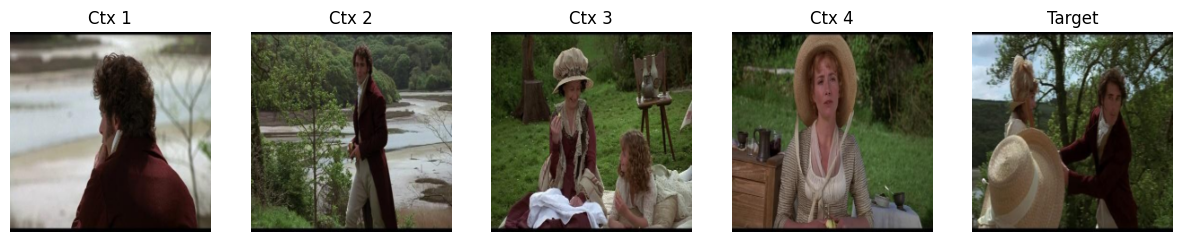

---- Context captions ----
[1] In the serene outdoor area with trees, Jane stood, her fingers lightly grazing the sleek surface of her cell phone. The tree branches swayed gently in the breeze, casting dappled shadows on the ground. She felt a mix of calm and anticipation, knowing that the day ahead would bring unexpected challenges. Little did she know, her actions would soon set off a chain of events that would test the bonds of friendship and loyalty.
[2] Meanwhile, John found himself near the river, his steps slow and measured as walked along the dirt path. The tree canopy above offered a sense of solitude, but he couldn't shake the feeling that something was amiss. As he gazed at the flowing water, his mind wandered to Jane and the mysterious message she had sent earlier. What secrets did she hold, and how would they affect their lives?
[3] In a nearby grassy area, Emily and Sarah shared a quiet moment. Emily held her handbag close, a symbol of the independence she cherished. Sara

In [9]:
# ============================================================
# Cell 7 — Visual sanity check (batched tensors)
# ============================================================

import matplotlib.pyplot as plt

def show_batch_sample(batch, idx=0):
    K = batch["ctx_images"].shape[1]
    ncols = K + 1
    plt.figure(figsize=(3*ncols, 3))

    for i in range(K):
        ax = plt.subplot(1, ncols, i+1)
        im = batch["ctx_images"][idx, i].permute(1,2,0).cpu().numpy()
        ax.imshow(im)
        ax.set_title(f"Ctx {i+1}")
        ax.axis("off")

    ax = plt.subplot(1, ncols, K+1)
    im = batch["tgt_image"][idx].permute(1,2,0).cpu().numpy()
    ax.imshow(im)
    ax.set_title("Target")
    ax.axis("off")
    plt.show()

    print("---- Context captions ----")
    for i, c in enumerate(batch["ctx_captions"][idx], start=1):
        print(f"[{i}] {c}")
    print("\n---- Target caption ----")
    print(batch["tgt_caption"][idx])

batch = next(iter(dl_train))
show_batch_sample(batch, idx=0)


In [10]:
# ============================================================
# Cell 8 — Install + load models (CLIP + GPT-2) + tokenization
#   - CLIP: used for alignment loss (and optional image embeddings)
#   - GPT-2: text decoder (caption generator)
#   - T4-friendly: keep CLIP frozen; train only small fusion + GPT-2 (LoRA optional later)
# ============================================================

!pip -q install transformers accelerate evaluate

import torch
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# CLIP for image-text embedding similarity (alignment)
clip_name = "openai/clip-vit-base-patch32"
clip = CLIPModel.from_pretrained(clip_name).to(device)
clip_processor = CLIPProcessor.from_pretrained(clip_name)

# Freeze CLIP (we only use it for embeddings)
for p in clip.parameters():
    p.requires_grad = False
clip.eval()

# GPT-2 for caption generation
gpt_name = "gpt2"
tok = AutoTokenizer.from_pretrained(gpt_name)
# GPT-2 has no pad token by default
if tok.pad_token is None:
    tok.pad_token = tok.eos_token

gpt = AutoModelForCausalLM.from_pretrained(gpt_name).to(device)

print("Loaded CLIP + GPT-2")


/usr/local/lib/python3.12/dist-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


device: cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loaded CLIP + GPT-2


In [16]:
# ============================================================
# Cell 9 (FIXED) — Prompt/target tokenization with target budget
#   Prevents "all labels = -100" -> NaN loss
# ============================================================

K = 4
MAX_LEN = 256          # increase a bit; still ok on T4 for batch=2-4
MAX_TGT_TOK = 64       # reserve this many tokens for target
MAX_CTX_WORDS = 25     # compress each context caption to keep prompt short

def compress_caption(c, max_words=MAX_CTX_WORDS):
    if not c:
        return ""
    w = c.split()
    return " ".join(w[:max_words])

def format_prompt(ctx_captions):
    # compact prompt
    lines = [f"{i+1}: {compress_caption(c)}" for i, c in enumerate(ctx_captions)]
    return "CTX\n" + "\n".join(lines) + "\nNEXT:"

def tokenize_batch(ctx_captions_batch, tgt_caption_batch):
    prompts = [format_prompt(caps) for caps in ctx_captions_batch]
    targets = [t if t else "" for t in tgt_caption_batch]

    # tokenize prompt with budget reserved for target
    max_prompt_len = MAX_LEN - MAX_TGT_TOK
    prompt_enc = tok(
        prompts,
        padding=False,
        truncation=True,
        max_length=max_prompt_len,
        add_special_tokens=False,
    )
    # tokenize target with its own cap
    tgt_enc = tok(
        targets,
        padding=False,
        truncation=True,
        max_length=MAX_TGT_TOK,
        add_special_tokens=False,
    )

    # build input_ids + labels per example
    input_ids_list, labels_list = [], []
    for p_ids, t_ids in zip(prompt_enc["input_ids"], tgt_enc["input_ids"]):
        # ensure at least 1 token supervised
        if len(t_ids) == 0:
            t_ids = [tok.eos_token_id]

        ids = p_ids + t_ids
        labels = ([-100] * len(p_ids)) + t_ids

        # clip to MAX_LEN as safety
        ids = ids[:MAX_LEN]
        labels = labels[:MAX_LEN]

        input_ids_list.append(torch.tensor(ids, dtype=torch.long))
        labels_list.append(torch.tensor(labels, dtype=torch.long))

    # pad to batch max
    max_b = max(x.size(0) for x in input_ids_list)
    input_ids = torch.full((len(input_ids_list), max_b), tok.pad_token_id, dtype=torch.long)
    labels    = torch.full((len(labels_list),    max_b), -100,            dtype=torch.long)
    attn_mask = torch.zeros((len(input_ids_list), max_b), dtype=torch.long)

    for i, (ids, lab) in enumerate(zip(input_ids_list, labels_list)):
        n = ids.size(0)
        input_ids[i, :n] = ids
        labels[i, :n]    = lab
        attn_mask[i, :n] = 1

    # sanity: ensure each row has supervised tokens
    supervised = (labels != -100).sum(dim=1)
    if (supervised == 0).any():
        bad = (supervised == 0).nonzero(as_tuple=True)[0].tolist()
        raise RuntimeError(f"Found samples with 0 supervised tokens: {bad}")

    enc = {"input_ids": input_ids, "attention_mask": attn_mask, "labels": labels}
    return enc, prompts


In [17]:
# ============================================================
# Cell 10 — Alignment loss (CLIP cosine) helper
#   We'll compute similarity between:
#     - target image (ground truth)  OR generated image later
#     - predicted caption (greedy)   OR ground truth caption early
#   For now: use GT image + (GT caption or greedy caption) to validate plumbing.
# ============================================================

import torch.nn.functional as F

@torch.no_grad()
def clip_embed_image_tensor(img_tensor_bchw):
    """
    img_tensor_bchw: torch float in [0,1], shape (B,3,224,224)
    Returns normalized CLIP image embeddings: (B,D)
    """
    # CLIPProcessor expects PIL or numpy; but CLIPModel can take pixel_values directly
    # We need normalization that processor applies. Use processor for correctness.
    imgs = []
    for i in range(img_tensor_bchw.size(0)):
        arr = (img_tensor_bchw[i].permute(1,2,0).cpu().numpy() * 255).astype("uint8")
        imgs.append(arr)
    inputs = clip_processor(images=imgs, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)
    emb = clip.get_image_features(pixel_values=pixel_values)
    emb = F.normalize(emb, dim=-1)
    return emb

@torch.no_grad()
def clip_embed_text(text_list):
    inputs = clip_processor(text=text_list, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    emb = clip.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
    emb = F.normalize(emb, dim=-1)
    return emb

def alignment_loss_from_gt(img_tensor_bchw, text_list):
    # (B,) cosine -> loss = 1 - mean(cos)
    img_emb = clip_embed_image_tensor(img_tensor_bchw)
    txt_emb = clip_embed_text(text_list)
    cos = (img_emb * txt_emb).sum(dim=-1)
    return (1.0 - cos).mean(), cos.detach().cpu()

# sanity: alignment on GT target caption vs GT target image
batch = next(iter(dl_train))
loss_align, cos_vals = alignment_loss_from_gt(batch["tgt_image"], batch["tgt_caption"])
print("GT alignment loss:", float(loss_align), "mean cos:", float(cos_vals.mean()))


GT alignment loss: 0.7522071599960327 mean cos: 0.24779285490512848


In [18]:
# ============================================================
# Cell 11 — Text-only baseline training (no NaNs)
#   - uses .detach().item() for logging
#   - checks finite loss
# ============================================================

from tqdm.auto import tqdm
import torch

gpt.train()

lr = 5e-5
optimizer = torch.optim.AdamW(gpt.parameters(), lr=lr)
num_epochs = 1
log_every = 50

def run_epoch_text(dl, train=True):
    if train:
        gpt.train()
    else:
        gpt.eval()

    total_loss = 0.0
    n = 0

    pbar = tqdm(dl, desc=("train" if train else "val"))
    for step, batch in enumerate(pbar):
        enc, _ = tokenize_batch(batch["ctx_captions"], batch["tgt_caption"])
        input_ids = enc["input_ids"].to(device)
        attention_mask = enc["attention_mask"].to(device)
        labels = enc["labels"].to(device)

        with torch.set_grad_enabled(train):
            out = gpt(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = out.loss

            # hard stop if NaN/Inf
            if not torch.isfinite(loss):
                print("Non-finite loss detected. Supervised tokens per sample:",
                      (labels != -100).sum(dim=1).detach().cpu().tolist())
                raise RuntimeError("Loss became non-finite.")

            if train:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(gpt.parameters(), 1.0)
                optimizer.step()

        bs = input_ids.size(0)
        loss_val = loss.detach().item()
        total_loss += loss_val * bs
        n += bs
        pbar.set_postfix(loss=loss_val, avg=(total_loss / max(n,1)))

    return total_loss / max(n,1)

train_loss = run_epoch_text(dl_train, train=True)
val_loss   = run_epoch_text(dl_val, train=False)
print("text-only baseline -> train loss:", train_loss, "val loss:", val_loss)


train:   0%|          | 0/711 [00:00<?, ?it/s]

val:   0%|          | 0/89 [00:00<?, ?it/s]

text-only baseline -> train loss: 2.2317885827195765 val loss: 2.0304952114400727


In [19]:
# ============================================================
# Cell 12 — Greedy generation sanity check (text-only)
# ============================================================

@torch.no_grad()
def generate_next_caption(ctx_caps, max_new_tokens=60):
    prompt = format_prompt(ctx_caps)
    inps = tok(prompt, return_tensors="pt").to(device)
    out_ids = gpt.generate(
        **inps,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        pad_token_id=tok.eos_token_id,
    )
    gen = tok.decode(out_ids[0], skip_special_tokens=True)
    # return only text after "NEXT:"
    return gen.split("NEXT:\n", 1)[-1].strip()

batch = next(iter(dl_val))
i = 0
print("PROMPT:\n", format_prompt(batch["ctx_captions"][i])[:500])
print("\nGT:\n", batch["tgt_caption"][i][:300])
pred = generate_next_caption(batch["ctx_captions"][i])
print("\nPRED:\n", pred[:400])


PROMPT:
 CTX
1: The flight had been uneventful until the air grew heavy with tension. Captain James stood near the aisle, his calm demeanor a stark contrast to
2: In the cockpit, the tension thickened. Captain James stood beside Co-pilot Smith, who was focused on the plane's controls. The tie around Co-pilot Smith's neck
3: The situation escalated as Captain James entered the dispatch office. Mr. Wilson, deep in thought, sat at the Dispatch Desk, his tie a testament to
4: Back in the cockpit, the tension

GT:
 The turning point came when Mr. Brown manipulated the controls on the Control panel. Every movement Mr. Brown's made was precise, his fingers moving with a practiced ease. The cockpit, now dimly lit, was a shadowy place, with the focus solely on Mr. Brown's actions. As Mr. Brown pressed the switch, 

PRED:
 CTX
1: The flight had been uneventful until the air grew heavy with tension. Captain James stood near the aisle, his calm demeanor a stark contrast to
2: In the cockpit, the t

In [20]:
# ============================================================
# Cell 13 — CLIP tensor normalization + fast embedding functions (no CLIPProcessor for images)
# ============================================================

import torch
import torch.nn.functional as F
from transformers import CLIPModel, CLIPProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_name = "openai/clip-vit-base-patch32"
clip = CLIPModel.from_pretrained(clip_name).to(device).eval()
clip_processor = CLIPProcessor.from_pretrained(clip_name)

for p in clip.parameters():
    p.requires_grad = False

# CLIP image normalization constants (OpenAI CLIP)
CLIP_MEAN = torch.tensor([0.48145466, 0.45782750, 0.40821073], device=device).view(1,3,1,1)
CLIP_STD  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device).view(1,3,1,1)

@torch.no_grad()
def clip_image_emb_from_tensor(img_bchw_01):
    """
    img_bchw_01: float tensor in [0,1], shape (B,3,224,224)
    returns: normalized CLIP image embedding (B,512)
    """
    x = (img_bchw_01.to(device) - CLIP_MEAN) / CLIP_STD
    emb = clip.get_image_features(pixel_values=x)
    return F.normalize(emb, dim=-1)

@torch.no_grad()
def clip_text_emb(text_list):
    """
    text_list: list[str]
    returns: normalized CLIP text embedding (B,512)
    """
    inputs = clip_processor(text=text_list, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    emb = clip.get_text_features(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
    return F.normalize(emb, dim=-1)

print("CLIP ready.")


CLIP ready.


In [21]:
# ============================================================
# Cell 14 — Shared encoder: fuse K context (CLIP img + CLIP text) -> z
# ============================================================

import torch.nn as nn

# compress context text for CLIP to reduce truncation/noise
MAX_CTX_WORDS_CLIP = 25
def compress_for_clip(c, max_words=MAX_CTX_WORDS_CLIP):
    if not c:
        return ""
    w = c.split()
    return " ".join(w[:max_words])

class SharedEncoder(nn.Module):
    def __init__(self, d_model=256, n_layers=2, n_heads=4, dropout=0.1):
        super().__init__()
        self.fuse = nn.Sequential(
            nn.Linear(512 + 512, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
        )
        self.temporal = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

    def forward(self, ctx_images_bkchw, ctx_captions_list):
        """
        ctx_images_bkchw: (B,K,3,224,224) in [0,1]
        ctx_captions_list: list length B, each is list[str] length K
        returns: z (B,d_model)
        """
        B, K, C, H, W = ctx_images_bkchw.shape
        imgs = ctx_images_bkchw.reshape(B*K, C, H, W)

        # CLIP image embeddings for K context frames
        with torch.no_grad():
            e_img = clip_image_emb_from_tensor(imgs)  # (B*K,512)

        # CLIP text embeddings for K context captions (flatten)
        flat_caps = []
        for caps in ctx_captions_list:
            for c in caps:
                flat_caps.append(compress_for_clip(c))
        with torch.no_grad():
            e_txt = clip_text_emb(flat_caps)          # (B*K,512)

        h = self.fuse(torch.cat([e_img, e_txt], dim=-1))  # (B*K,d_model)
        h = h.reshape(B, K, -1)                            # (B,K,d_model)

        h = self.temporal(h)                               # (B,K,d_model)
        z = h.mean(dim=1)                                  # (B,d_model)
        return z

print("SharedEncoder defined.")


SharedEncoder defined.


In [22]:
# ============================================================
# Cell 15 — GPT-2 prefix conditioning + pooled text embedding
#   z -> prefix embeddings (B, P, 768)
# ============================================================

from transformers import AutoTokenizer, AutoModelForCausalLM

gpt_name = "gpt2"
tok = AutoTokenizer.from_pretrained(gpt_name)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token

gpt = AutoModelForCausalLM.from_pretrained(gpt_name).to(device)

class PrefixGPT2(nn.Module):
    def __init__(self, gpt_model, d_z=256, n_prefix=8):
        super().__init__()
        self.gpt = gpt_model
        self.n_prefix = n_prefix
        self.z_to_prefix = nn.Linear(d_z, n_prefix * self.gpt.config.n_embd)
        self.txt_proj = nn.Linear(self.gpt.config.n_embd, 512)  # to compare with CLIP/image emb

    def forward(self, input_ids, attention_mask, labels, z):
        """
        input_ids: (B,T)
        labels:    (B,T) with -100 for prompt positions
        z:         (B,d_z)
        Returns: text_loss, txt_emb (B,512), outputs
        """
        B, T = input_ids.shape
        # token embeddings
        tok_emb = self.gpt.transformer.wte(input_ids)  # (B,T,768)

        # prefix embeddings from z
        prefix = self.z_to_prefix(z).view(B, self.n_prefix, -1)  # (B,P,768)

        # concat prefix + tokens
        inputs_embeds = torch.cat([prefix, tok_emb], dim=1)      # (B,P+T,768)

        # extend attention mask
        prefix_mask = torch.ones((B, self.n_prefix), dtype=attention_mask.dtype, device=attention_mask.device)
        attn = torch.cat([prefix_mask, attention_mask], dim=1)   # (B,P+T)

        # extend labels: prefix labels are ignored
        prefix_labels = torch.full((B, self.n_prefix), -100, dtype=labels.dtype, device=labels.device)
        lab = torch.cat([prefix_labels, labels], dim=1)          # (B,P+T)

        out = self.gpt(
            inputs_embeds=inputs_embeds,
            attention_mask=attn,
            labels=lab,
            output_hidden_states=True,
            use_cache=False,
        )
        text_loss = out.loss

        # pooled hidden representation over supervised target positions (labels != -100)
        hs = out.hidden_states[-1]  # (B,P+T,768)
        mask = (lab != -100).float().unsqueeze(-1)  # (B,P+T,1)
        denom = mask.sum(dim=1).clamp(min=1.0)
        pooled = (hs * mask).sum(dim=1) / denom     # (B,768)

        txt_emb = F.normalize(self.txt_proj(pooled), dim=-1)     # (B,512)
        return text_loss, txt_emb, out

print("PrefixGPT2 ready.")


PrefixGPT2 ready.


In [24]:
# ============================================================
# Cell 16 — Project 4 full model: shared encoder + image head + alignment loss
#   L_total = L_txt + alpha*L_img + lambda*L_align
#   - L_img: predict target CLIP image embedding (regression)
#   - L_align: cosine between predicted image emb and text emb (both model-dependent)
# ============================================================

class Project4Model(nn.Module):
    def __init__(self, d_model=256, n_prefix=8):
        super().__init__()
        self.encoder = SharedEncoder(d_model=d_model)
        self.textdec = PrefixGPT2(gpt, d_z=d_model, n_prefix=n_prefix)

        # "Image decoder": predict CLIP image embedding of target from z
        self.img_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 512),
        )

    def forward(self, batch, enc_fn):
        """
        batch from dataloader: ctx_images, ctx_captions, tgt_image, tgt_caption
        enc_fn: tokenize_batch function returning input_ids/attn/labels for GPT2
        """
        ctx_images = batch["ctx_images"].to(device)   # (B,K,3,224,224) [0,1]
        tgt_image  = batch["tgt_image"].to(device)    # (B,3,224,224) [0,1]

        # z from shared encoder (uses frozen CLIP inside)
        z = self.encoder(ctx_images, batch["ctx_captions"])  # (B,d_model)

        # tokenize prompt+target for GPT2
        enc, _ = enc_fn(batch["ctx_captions"], batch["tgt_caption"])
        input_ids = enc["input_ids"].to(device)
        attn_mask = enc["attention_mask"].to(device)
        labels    = enc["labels"].to(device)

        # text decoder
        text_loss, txt_emb, _ = self.textdec(input_ids, attn_mask, labels, z)

        # target CLIP image embedding (frozen)
        with torch.no_grad():
            tgt_img_emb = clip_image_emb_from_tensor(tgt_image)  # (B,512)

        # predicted image embedding
        pred_img_emb = F.normalize(self.img_head(z), dim=-1)     # (B,512)

        # losses
        img_loss = F.mse_loss(pred_img_emb, tgt_img_emb)
        align_loss = (1.0 - (pred_img_emb * txt_emb).sum(dim=-1)).mean()

        return text_loss, img_loss, align_loss

model = Project4Model(d_model=256, n_prefix=8).to(device)
print("Model initialized.")


Model initialized.


In [25]:
# ============================================================
# Cell 17 — Train Project 4 (tqdm + AMP). T4-friendly settings.
# ============================================================

from tqdm.auto import tqdm

# IMPORTANT: use the robust tokenize_batch (target-first) that fixed your NaNs.
# It must exist in your notebook (the v2 version you used to fix NaNs).

alpha_img = 0.5   # weight for image embedding regression
lambda_align = 0.5  # weight for alignment loss

# Train only lightweight parts first (recommended):
# freeze GPT-2 base weights and train prefix + shared encoder + img head
for p in model.textdec.gpt.parameters():
    p.requires_grad = False
# keep prefix projection + txt_proj trainable
for p in model.textdec.z_to_prefix.parameters():
    p.requires_grad = True
for p in model.textdec.txt_proj.parameters():
    p.requires_grad = True

# shared encoder + img head are trainable by default

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=2e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))

def run_epoch_project4(dl, train=True):
    model.train(train)
    total = {"txt":0.0, "img":0.0, "align":0.0, "tot":0.0}
    n = 0

    pbar = tqdm(dl, desc=("p4-train" if train else "p4-val"))
    for batch in pbar:
        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            txt_loss, img_loss, align_loss = model(batch, tokenize_batch)
            loss = txt_loss + alpha_img * img_loss + lambda_align * align_loss

        if not torch.isfinite(loss):
            raise RuntimeError("Non-finite loss training.")

        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(params, 1.0)
            scaler.step(optimizer)
            scaler.update()

        bs = batch["tgt_image"].shape[0]
        total["txt"] += txt_loss.detach().item() * bs
        total["img"] += img_loss.detach().item() * bs
        total["align"] += align_loss.detach().item() * bs
        total["tot"] += loss.detach().item() * bs
        n += bs

        pbar.set_postfix(
            tot=total["tot"]/n,
            txt=total["txt"]/n,
            img=total["img"]/n,
            al=total["align"]/n
        )

    for k in total:
        total[k] /= max(n,1)
    return total

EPOCHS = 2  # start small
for ep in range(1, EPOCHS+1):
    tr = run_epoch_project4(dl_train, train=True)
    va = run_epoch_project4(dl_val, train=False)
    print(f"Epoch {ep} | train:", tr, "| val:", va)


/tmp/ipython-input-3708026907.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))


p4-train:   0%|          | 0/711 [00:00<?, ?it/s]

/tmp/ipython-input-3708026907.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


p4-val:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1 | train: {'txt': 2.8431193124488474, 'img': 0.003448822434279584, 'align': 0.018626334108294253, 'tot': 2.854156891840606} | val: {'txt': 2.56194413749265, 'img': 0.0029778703430693755, 'align': 0.0008266954358116212, 'tot': 2.5638464128467398}


p4-train:   0%|          | 0/711 [00:00<?, ?it/s]

p4-val:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2 | train: {'txt': 2.752228596142504, 'img': 0.0025274162005340705, 'align': 0.0005015526301254063, 'tot': 2.7537430777007614} | val: {'txt': 2.5441330271707456, 'img': 0.0021122904107446824, 'align': 0.0005229212868381554, 'tot': 2.54545063502352}


In [26]:
# ============================================================
# Cell 19 — Evaluation metrics (Project 4)
# ============================================================

from tqdm.auto import tqdm
import numpy as np

@torch.no_grad()
def eval_project4(dl, gen_caption=False, max_new_tokens=48):
    model.eval()
    stats = {
        "cos_predimg_tgtimg": [],
        "cos_predimg_txtemb": [],
        "cos_tgtimg_gtcliptxt": [],
        "cos_tgtimg_predcliptxt": [],
        "txt_loss": [],
    }

    pbar = tqdm(dl, desc=f"eval (gen_caption={gen_caption})")
    for batch in pbar:
        # z
        ctx_images = batch["ctx_images"].to(device)
        tgt_image  = batch["tgt_image"].to(device)

        z = model.encoder(ctx_images, batch["ctx_captions"])

        # text loss + txt_emb (uses GT target for supervision)
        enc, _ = tokenize_batch(batch["ctx_captions"], batch["tgt_caption"])
        input_ids = enc["input_ids"].to(device)
        attn_mask = enc["attention_mask"].to(device)
        labels    = enc["labels"].to(device)

        txt_loss, txt_emb, _ = model.textdec(input_ids, attn_mask, labels, z)

        # embeddings
        tgt_img_emb = clip_image_emb_from_tensor(tgt_image)
        pred_img_emb = torch.nn.functional.normalize(model.img_head(z), dim=-1)

        cos1 = (pred_img_emb * tgt_img_emb).sum(dim=-1)     # (B,)
        cos2 = (pred_img_emb * txt_emb).sum(dim=-1)         # (B,)

        # CLIP text embedding of GT caption
        gt_txt_emb = clip_text_emb(batch["tgt_caption"])
        cos3 = (tgt_img_emb * gt_txt_emb).sum(dim=-1)

        stats["cos_predimg_tgtimg"] += cos1.detach().cpu().tolist()
        stats["cos_predimg_txtemb"] += cos2.detach().cpu().tolist()
        stats["cos_tgtimg_gtcliptxt"] += cos3.detach().cpu().tolist()
        stats["txt_loss"].append(float(txt_loss.detach().cpu()))

        # optional: generate caption and compute CLIPScore (slower)
        if gen_caption:
            # greedy decode with prefix conditioning; one-by-one to keep it simple
            preds = []
            for i in range(len(batch["ctx_captions"])):
                prompt = format_prompt(batch["ctx_captions"][i])
                inp = tok(prompt, return_tensors="pt", add_special_tokens=False).to(device)
                pid = inp["input_ids"]
                am  = inp["attention_mask"]

                z_i = z[i:i+1]
                prefix = model.textdec.z_to_prefix(z_i).view(1, model.textdec.n_prefix, -1)
                tok_emb = model.textdec.gpt.transformer.wte(pid)
                inputs_embeds = torch.cat([prefix, tok_emb], dim=1)
                prefix_mask = torch.ones((1, model.textdec.n_prefix), dtype=am.dtype, device=device)
                am2 = torch.cat([prefix_mask, am], dim=1)

                out = model.textdec.gpt.generate(
                    inputs_embeds=inputs_embeds,
                    attention_mask=am2,
                    max_new_tokens=max_new_tokens,
                    do_sample=False,
                    pad_token_id=tok.eos_token_id,
                )
                # decode only new tokens
                new_ids = out[0, pid.shape[1]:]
                preds.append(tok.decode(new_ids, skip_special_tokens=True).strip())

            pred_txt_emb = clip_text_emb(preds)
            cos4 = (tgt_img_emb * pred_txt_emb).sum(dim=-1)
            stats["cos_tgtimg_predcliptxt"] += cos4.detach().cpu().tolist()

        pbar.set_postfix(
            cos_predimg_tgtimg=np.mean(stats["cos_predimg_tgtimg"][-64:]) if stats["cos_predimg_tgtimg"] else 0.0,
            cos_predimg_txt=np.mean(stats["cos_predimg_txtemb"][-64:]) if stats["cos_predimg_txtemb"] else 0.0,
        )

    # summarize
    summary = {}
    for k, v in stats.items():
        if len(v) == 0:
            summary[k] = None
        else:
            summary[k] = float(np.mean(v))
    return summary

val_metrics = eval_project4(dl_val, gen_caption=False)
test_metrics = eval_project4(dl_test, gen_caption=False)

print("VAL:", val_metrics)
print("TEST:", test_metrics)


eval (gen_caption=False):   0%|          | 0/89 [00:00<?, ?it/s]

eval (gen_caption=False):   0%|          | 0/89 [00:00<?, ?it/s]

VAL: {'cos_predimg_tgtimg': 0.4592411623874181, 'cos_predimg_txtemb': 0.9994768340822676, 'cos_tgtimg_gtcliptxt': 0.2494766718065235, 'cos_tgtimg_predcliptxt': None, 'txt_loss': 2.5435922520883967}
TEST: {'cos_predimg_tgtimg': 0.45790889641542115, 'cos_predimg_txtemb': 0.9994771795326405, 'cos_tgtimg_gtcliptxt': 0.25229834802867324, 'cos_tgtimg_predcliptxt': None, 'txt_loss': 2.5589791764034313}


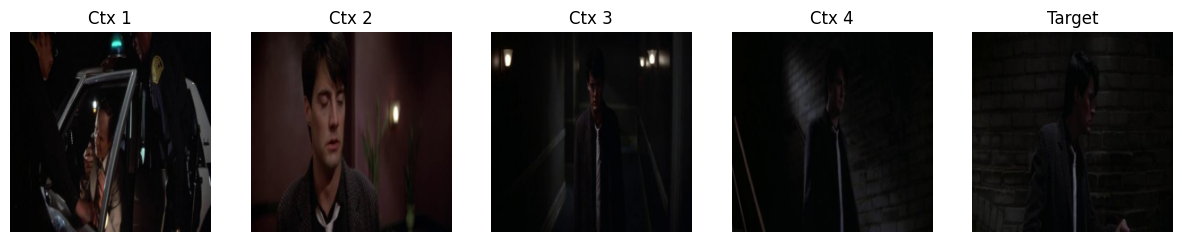

---- Context captions ----
[1] The night was thick with tension as Jack sat inside the car, illuminated by the harsh glow of the car light and car light. His tie was a stark contrast to the dark interior. Outside, Officer Smith stood authoritatively, casting a shadow over the situation with Officer Brown observing intently. Jack held something in his hand, perhaps a drink, his expression a mix of concern and defiance. The weight of the night settled on his shoulders as Officer Smith spoke, “We’ve been watching you, Jack. Your actions have consequences.” Jack’s mind raced. He knew he was in deep trouble, but he also knew that he couldn’t let Officer Smith and Officer Brown have the last word. Jack took a deep breath, steeling himself for what was to come. Little did he know, the night was far from over.
[2] Meanwhile, David found himself alone in a dimly lit room, the interior design providing a stark contrast to the turmoil within him. The potted plant and potted plant in the backgroun

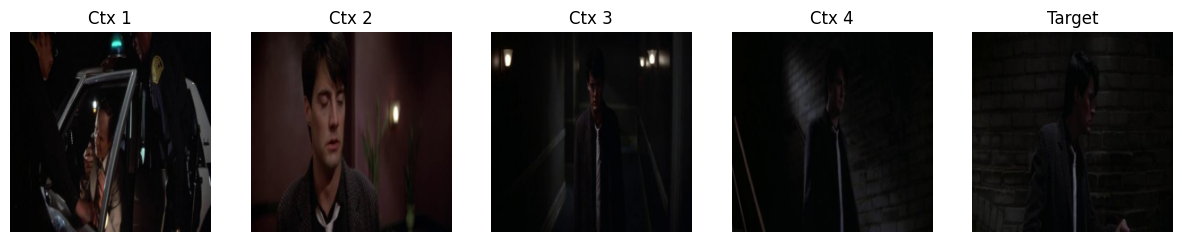

---- Context captions ----
[1] The night was thick with tension as Jack sat inside the car, illuminated by the harsh glow of the car light and car light. His tie was a stark contrast to the dark interior. Outside, Officer Smith stood authoritatively, casting a shadow over the situation with Officer Brown observing intently. Jack held something in his hand, perhaps a drink, his expression a mix of concern and defiance. The weight of the night settled on his shoulders as Officer Smith spoke, “We’ve been watching you, Jack. Your actions have consequences.” Jack’s mind raced. He knew he was in deep trouble, but he also knew that he couldn’t let Officer Smith and Officer Brown have the last word. Jack took a deep breath, steeling himself for what was to come. Little did he know, the night was far from over.
[2] Meanwhile, David found himself alone in a dimly lit room, the interior design providing a stark contrast to the turmoil within him. The potted plant and potted plant in the backgroun

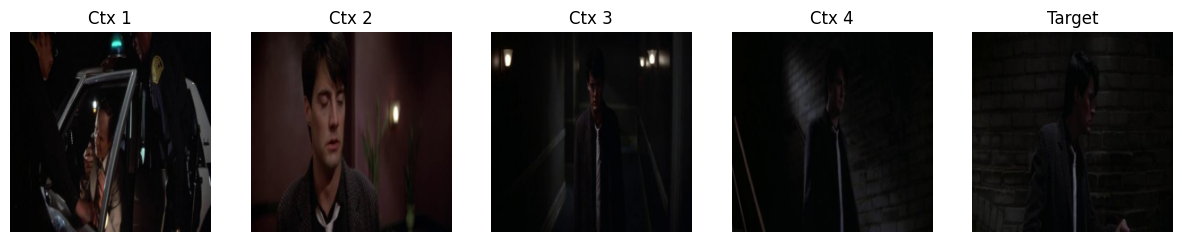

---- Context captions ----
[1] The night was thick with tension as Jack sat inside the car, illuminated by the harsh glow of the car light and car light. His tie was a stark contrast to the dark interior. Outside, Officer Smith stood authoritatively, casting a shadow over the situation with Officer Brown observing intently. Jack held something in his hand, perhaps a drink, his expression a mix of concern and defiance. The weight of the night settled on his shoulders as Officer Smith spoke, “We’ve been watching you, Jack. Your actions have consequences.” Jack’s mind raced. He knew he was in deep trouble, but he also knew that he couldn’t let Officer Smith and Officer Brown have the last word. Jack took a deep breath, steeling himself for what was to come. Little did he know, the night was far from over.
[2] Meanwhile, David found himself alone in a dimly lit room, the interior design providing a stark contrast to the turmoil within him. The potted plant and potted plant in the backgroun

In [28]:
# ============================================================
# CELL 20 — Qualitative samples (FIXED generation)
# Works with your current `model` (Project4Model) and also with `model2` (Project4Model_v2).
# Requirements: format_prompt, tok, clip_image_emb_from_tensor, clip_text_emb already defined.
# ============================================================

import matplotlib.pyplot as plt
import random
import torch

@torch.no_grad()
def generate_one_caption_prefix(any_model, ctx_images_1k, ctx_caps_1k, max_new_tokens=60):
    """
    Robust generation for prefix-conditioned GPT-2 using inputs_embeds:
    - Decode full output
    - Extract content after 'NEXT:' marker
    """
    any_model.eval()

    # Build z
    z = any_model.encoder(ctx_images_1k.to(device), [ctx_caps_1k])

    prompt = format_prompt(ctx_caps_1k)
    inp = tok(prompt, return_tensors="pt", add_special_tokens=False).to(device)
    pid = inp["input_ids"]
    am  = inp["attention_mask"]

    # Prefix embeddings + token embeddings
    prefix = any_model.textdec.z_to_prefix(z).view(1, any_model.textdec.n_prefix, -1)
    tok_emb = any_model.textdec.gpt.transformer.wte(pid)
    inputs_embeds = torch.cat([prefix, tok_emb], dim=1)

    prefix_mask = torch.ones((1, any_model.textdec.n_prefix), dtype=am.dtype, device=device)
    am2 = torch.cat([prefix_mask, am], dim=1)

    out_ids = any_model.textdec.gpt.generate(
        inputs_embeds=inputs_embeds,
        attention_mask=am2,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        pad_token_id=tok.eos_token_id,
    )

    full = tok.decode(out_ids[0], skip_special_tokens=True)

    # Extract after marker
    if "NEXT:" in full:
        pred = full.split("NEXT:", 1)[-1].strip()
    elif "NEXT:\n" in full:
        pred = full.split("NEXT:\n", 1)[-1].strip()
    else:
        # fallback: remove prompt if present verbatim
        pred = full.replace(prompt, "", 1).strip()

    # avoid truly empty output
    if len(pred.strip()) == 0:
        pred = " "

    return pred

def show_batch_sample_with_pred(dl, any_model, idx=None, max_new_tokens=60):
    batch = next(iter(dl))
    B = batch["ctx_images"].shape[0]
    i = random.randint(0, B-1) if idx is None else idx

    K_local = batch["ctx_images"].shape[1]
    ncols = K_local + 1
    plt.figure(figsize=(3*ncols, 3))

    for j in range(K_local):
        ax = plt.subplot(1, ncols, j+1)
        ax.imshow(batch["ctx_images"][i,j].permute(1,2,0).cpu().numpy())
        ax.set_title(f"Ctx {j+1}")
        ax.axis("off")

    ax = plt.subplot(1, ncols, K_local+1)
    ax.imshow(batch["tgt_image"][i].permute(1,2,0).cpu().numpy())
    ax.set_title("Target")
    ax.axis("off")
    plt.show()

    gt = batch["tgt_caption"][i]
    pred = generate_one_caption_prefix(any_model, batch["ctx_images"][i:i+1], batch["ctx_captions"][i], max_new_tokens=max_new_tokens)

    # CLIP cosine scores
    tgt_img_emb = clip_image_emb_from_tensor(batch["tgt_image"][i:i+1].to(device))
    gt_txt_emb  = clip_text_emb([gt])
    pr_txt_emb  = clip_text_emb([pred])

    cos_gt   = float((tgt_img_emb * gt_txt_emb).sum(dim=-1).cpu())
    cos_pred = float((tgt_img_emb * pr_txt_emb).sum(dim=-1).cpu())

    print("---- Context captions ----")
    for k, c in enumerate(batch["ctx_captions"][i], start=1):
        print(f"[{k}] {c}")
    print("\nGT caption:\n", gt[:700], "\n")
    print("PRED caption:\n", pred[:700], "\n")
    print("CLIP cosine(tgt_img, GT_caption):  ", cos_gt)
    print("CLIP cosine(tgt_img, PRED_caption):", cos_pred)

# Run 3 qualitative samples on VAL
for _ in range(3):
    show_batch_sample_with_pred(dl_val, model, idx=None, max_new_tokens=60)  # change model -> model2 if using v2


In [30]:
# ============================================================
# Cell 21 — Alignment loss uses frozen CLIP text embeddings (fix collapse)
#   L_align = 1 - cos(pred_img_emb, CLIP_text(GT_caption))
# ============================================================

import torch.nn.functional as F

class Project4Model_v2(nn.Module):
    def __init__(self, d_model=256, n_prefix=8):
        super().__init__()
        self.encoder = SharedEncoder(d_model=d_model)
        self.textdec = PrefixGPT2(gpt, d_z=d_model, n_prefix=n_prefix)
        self.img_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 512),
        )

    def forward(self, batch, enc_fn):
        ctx_images = batch["ctx_images"].to(device)
        tgt_image  = batch["tgt_image"].to(device)

        z = self.encoder(ctx_images, batch["ctx_captions"])

        enc, _ = enc_fn(batch["ctx_captions"], batch["tgt_caption"])
        input_ids = enc["input_ids"].to(device)
        attn_mask = enc["attention_mask"].to(device)
        labels    = enc["labels"].to(device)

        # text loss (still useful for language quality)
        text_loss, _, _ = self.textdec(input_ids, attn_mask, labels, z)

        # target image emb (frozen)
        with torch.no_grad():
            tgt_img_emb = clip_image_emb_from_tensor(tgt_image)

        pred_img_emb = F.normalize(self.img_head(z), dim=-1)

        img_loss = F.mse_loss(pred_img_emb, tgt_img_emb)

        # CLIP text emb of GT target caption (frozen) -> stable alignment signal
        with torch.no_grad():
            gt_txt_emb = clip_text_emb(batch["tgt_caption"])
        align_loss = (1.0 - (pred_img_emb * gt_txt_emb).sum(dim=-1)).mean()

        return text_loss, img_loss, align_loss

model2 = Project4Model_v2(d_model=256, n_prefix=8).to(device)
print("Project v2 ready (alignment uses CLIP text).")


Project v2 ready (alignment uses CLIP text).


In [31]:
# ============================================================
# Cell 22 — Train Project v2
# ============================================================

from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm

alpha_img = 0.5
lambda_align = 0.5

# Freeze GPT-2 weights, train prefix mapping + shared encoder + img head
for p in model2.textdec.gpt.parameters():
    p.requires_grad = False
for p in model2.parameters():
    if p.requires_grad is None:
        p.requires_grad = True

params = [p for p in model2.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=2e-4)
scaler = GradScaler("cuda", enabled=(device == "cuda"))

def run_epoch_p4v2(dl, train=True):
    model2.train(train)
    total = {"txt":0.0, "img":0.0, "align":0.0, "tot":0.0}
    n = 0
    pbar = tqdm(dl, desc=("p4v2-train" if train else "p4v2-val"))
    for batch in pbar:
        with autocast("cuda", enabled=(device=="cuda")):
            txt_loss, img_loss, align_loss = model2(batch, tokenize_batch)
            loss = txt_loss + alpha_img * img_loss + lambda_align * align_loss

        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(params, 1.0)
            scaler.step(optimizer)
            scaler.update()

        bs = batch["tgt_image"].shape[0]
        total["txt"] += txt_loss.detach().item() * bs
        total["img"] += img_loss.detach().item() * bs
        total["align"] += align_loss.detach().item() * bs
        total["tot"] += loss.detach().item() * bs
        n += bs
        pbar.set_postfix(tot=total["tot"]/n, txt=total["txt"]/n, img=total["img"]/n, al=total["align"]/n)

    for k in total:
        total[k] /= max(n,1)
    return total

for ep in range(1, 3):
    tr = run_epoch_p4v2(dl_train, train=True)
    va = run_epoch_p4v2(dl_val, train=False)
    print(f"Epoch {ep} | train:", tr, "| val:", va)


p4v2-train:   0%|          | 0/711 [00:00<?, ?it/s]

p4v2-val:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1 | train: {'txt': 2.837480090277919, 'img': 0.0029821275039754653, 'align': 0.17767621446184523, 'tot': 2.92780926562413} | val: {'txt': 2.5519390300965643, 'img': 0.0029350703621519284, 'align': 0.15741117642798894, 'tot': 2.6321121706089503}


p4v2-train:   0%|          | 0/711 [00:00<?, ?it/s]

p4v2-val:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2 | train: {'txt': 2.740077872378689, 'img': 0.002957815608610909, 'align': 0.15067698134372284, 'tot': 2.816895273192505} | val: {'txt': 2.532609486244094, 'img': 0.002980054634898691, 'align': 0.15577811124459118, 'tot': 2.61198857670099}


In [32]:
# ============================================================
# CELL 23 — Proper CLIPScore evaluation on generated captions (tqdm)
# Works with `model` or `model2`.
# ============================================================

import numpy as np
from tqdm.auto import tqdm

@torch.no_grad()
def eval_clipscore_generated(dl, any_model, n_batches=30, max_new_tokens=48):
    any_model.eval()
    scores = []

    total = min(n_batches, len(dl))
    pbar = tqdm(enumerate(dl), total=total, desc="CLIPScore(gen)")

    for bi, batch in pbar:
        if bi >= n_batches:
            break

        B = batch["tgt_image"].shape[0]
        tgt_img_emb = clip_image_emb_from_tensor(batch["tgt_image"].to(device))  # (B,512)

        preds = []
        for i in range(B):
            pred = generate_one_caption_prefix(any_model, batch["ctx_images"][i:i+1], batch["ctx_captions"][i], max_new_tokens=max_new_tokens)
            preds.append(pred)

        pred_txt_emb = clip_text_emb(preds)  # (B,512)
        cos = (tgt_img_emb * pred_txt_emb).sum(dim=-1).detach().cpu().numpy()
        scores.extend(cos.tolist())

        pbar.set_postfix(mean=float(np.mean(scores)))

    return float(np.mean(scores))

val_clip = eval_clipscore_generated(dl_val, model, n_batches=30, max_new_tokens=48)   # change model -> model2 if using v2
test_clip = eval_clipscore_generated(dl_test, model, n_batches=30, max_new_tokens=48)

print("VAL CLIPScore(tgt_img, pred_caption):", val_clip)
print("TEST CLIPScore(tgt_img, pred_caption):", test_clip)


CLIPScore(gen):   0%|          | 0/30 [00:00<?, ?it/s]

CLIPScore(gen):   0%|          | 0/30 [00:00<?, ?it/s]

VAL CLIPScore(tgt_img, pred_caption): 0.24685287301739056
TEST CLIPScore(tgt_img, pred_caption): 0.24265274244050186
